# 🤟 ASL (American Sign Language) 알파벳 분류기 (Linear Layer)

이 노트북은 **Fully Connected Layer (nn.Linear)**만을 사용하여 수화 알파벳(A-Z) 이미지를 분류하는 딥러닝 모델을 구현합니다.
CNN을 사용하지 않고, 기본적인 신경망 구조로 어느 정도의 성능을 낼 수 있는지 확인해 봅니다.

### 주요 특징
- **모델**: nn.Linear 층으로만 구성 (Input -> Hidden -> Output)
- **입력**: 28x28 이미지를 784차원 벡터로 평탄화(Flatten)
- **데이터**: Sign Language MNIST (CSV)


In [33]:
# Colab 환경 설정 및 데이터 경로 지정
import os
import sys

try:
    from google.colab import drive
    is_colab = True
    print("Google Colab 환경이 감지되었습니다.")
except ImportError:
    is_colab = False
    print("로컬 환경(VS Code 등)이 감지되었습니다.")

if is_colab:
    # Google Drive 마운트 (VS Code에서 실행 시 인증 절차가 필요할 수 있음)
    print("Google Drive 마운트를 시도합니다. 인증 링크가 나타나면 클릭하여 인증 코드를 복사해 주세요.")
    try:
        drive.mount('/content/drive', force_remount=True)
        print("Google Drive 마운트 성공!")
        # Colab에서의 데이터 경로
        DATA_PATH = '/content/drive/MyDrive/강의자료/Vibe_Coding/data/asl_data'
    except Exception as e:
        print(f"Google Drive 마운트 실패: {e}")
        print("VS Code에서 실행 중이라면, 브라우저에서 Colab을 열어 실행하거나 데이터를 직접 업로드해야 할 수 있습니다.")
        print("로컬 경로를 시도합니다.")
        DATA_PATH = './data/asl_data'
else:
    # 로컬 환경 데이터 경로
    DATA_PATH = './data/asl_data'

print(f"데이터 경로: {DATA_PATH}")

Google Colab 환경이 감지되었습니다.
Google Drive 마운트를 시도합니다. 인증 링크가 나타나면 클릭하여 인증 코드를 복사해 주세요.
Google Drive 마운트 실패: mount failed
VS Code에서 실행 중이라면, 브라우저에서 Colab을 열어 실행하거나 데이터를 직접 업로드해야 할 수 있습니다.
로컬 경로를 시도합니다.
데이터 경로: ./data/asl_data


In [ ]:
# Colab 환경 설정 및 데이터 경로 지정
import os
import sys

try:
    from google.colab import drive
    is_colab = True
    print("Google Colab 환경이 감지되었습니다.")
except ImportError:
    is_colab = False
    print("로컬 환경(VS Code 등)이 감지되었습니다.")

if is_colab:
    # Google Drive 마운트 (VS Code에서 실행 시 인증 절차가 필요할 수 있음)
    print("Google Drive 마운트를 시도합니다. 인증 링크가 나타나면 클릭하여 인증 코드를 복사해 주세요.")
    try:
        drive.mount('/content/drive')
        print("Google Drive 마운트 성공!")
    except Exception as e:
        print(f"Google Drive 마운트 실패: {e}")
        print("VS Code에서 실행 중이라면, 브라우저에서 Colab을 열어 실행하거나 데이터를 직접 업로드해야 할 수 있습니다.")

    # Colab에서의 데이터 경로 (사용자의 Drive 구조에 맞춰 수정 필요)
    # h:\내 드라이브 -> /content/drive/MyDrive 로 매핑됨
    # DATA_PATH = '/content/drive/MyDrive/강의자료/Vibe_Coding/data/asl_data'
    DATA_PATH = '/content/drive/data/asl_data'

else:
    # 로컬 환경 데이터 경로
    DATA_PATH = './data/asl_data'

print(f"데이터 경로: {DATA_PATH}")

Google Colab 환경이 감지되었습니다.
Google Drive 마운트를 시도합니다. 인증 링크가 나타나면 클릭하여 인증 코드를 복사해 주세요.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 성공!
데이터 경로: /content/drive/data/asl_data


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
from torchvision import transforms

# 한글 폰트 설정 (필요시)
import matplotlib as mpl
import matplotlib.font_manager as fm

# def set_korean_font():
#     for font_name in ["Malgun Gothic", "NanumGothic", "AppleGothic", "D2Coding"]:
#         try:
#             fm.findfont(font_name, fallback_to_default=False)
#             mpl.rcParams["font.family"] = font_name
#             mpl.rcParams["axes.unicode_minus"] = False
#             return font_name
#         except Exception:
#             continue
#     return None

# set_korean_font()

## 1. 하이퍼파라미터 설정

학습에 필요한 주요 파라미터를 설정합니다.

In [36]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
NUM_CLASSES = 26
INPUT_SIZE = 28 * 28  # 784
HIDDEN_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"사용 디바이스: {DEVICE}")

사용 디바이스: cpu


## 2. 데이터셋 클래스 정의

CSV 파일에서 데이터를 로드하고 전처리하는 커스텀 데이터셋 클래스입니다.

In [37]:
class ASLDataset(Dataset):
    """ASL 데이터셋 클래스"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            # 이미 Tensor가 아니라면 변환
            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(image).float()

            # Flatten이 안되어 있다면 (1, 28, 28) -> (784)
            # 하지만 여기서는 2D 이미지로 유지하고 모델 내부에서 Flatten 할 수도 있고,
            # 미리 Flatten 할 수도 있습니다.
            # transforms.ToTensor()를 쓰면 (1, 28, 28)이 되므로 모델에서 Flatten 하는게 일반적입니다.
            pass

        label = torch.tensor(label, dtype=torch.long)
        return image, label

## 3. 데이터 로드 및 분할

데이터를 로드하고 Train(70%) / Valid(20%) / Test(10%)로 분할합니다.

In [38]:
# 데이터 전처리
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),  # (1, 28, 28)로 변환, 값은 0~1로 정규화됨
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# 데이터 로드
data_dir = DATA_PATH
train_csv = os.path.join(data_dir, "sign_mnist_train.csv")

if os.path.exists(train_csv):
    print("CSV 파일 로드 중...")
    df_train = pd.read_csv(train_csv)

    # 라벨과 이미지 분리
    labels = df_train.iloc[:, 0].values
    images = df_train.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)

    # 데이터 분할 (70% / 20% / 10%)
    total_size = len(images)
    indices = np.arange(total_size)
    np.random.seed(42)
    np.random.shuffle(indices)

    split1 = int(total_size * 0.70)
    split2 = int(total_size * 0.90)

    train_idx = indices[:split1]
    valid_idx = indices[split1:split2]
    test_idx = indices[split2:]

    # 데이터셋 생성
    train_dataset = ASLDataset(images[train_idx], labels[train_idx], transform=train_transform)
    valid_dataset = ASLDataset(images[valid_idx], labels[valid_idx], transform=test_transform)
    test_dataset = ASLDataset(images[test_idx], labels[test_idx], transform=test_transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"데이터 분할 완료:")
    print(f"  Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
    print(f"  Valid: {len(valid_dataset)} ({len(valid_dataset)/total_size*100:.1f}%)")
    print(f"  Test : {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")
else:
    print(f"파일을 찾을 수 없습니다: {train_csv}")

파일을 찾을 수 없습니다: ./data/asl_data/sign_mnist_train.csv


## 4. Linear 모델 정의

CNN을 사용하지 않고, `nn.Linear` 층으로만 구성된 모델을 정의합니다.
입력 이미지는 `view` 함수를 통해 1차원 벡터로 펼쳐집니다 (Flatten).

In [39]:
class ASL_Linear_Classifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=26):
        super(ASL_Linear_Classifier, self).__init__()
        # 입력층 -> 은닉층
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # 은닉층 -> 출력층
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten: (Batch, 1, 28, 28) -> (Batch, 784)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ASL_Linear_Classifier(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(DEVICE)
print(model)

ASL_Linear_Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=26, bias=True)
)


## 5. 학습 및 검증

모델을 학습하고 검증 데이터로 성능을 평가합니다.

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

print("학습 시작...")

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Train Accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Valid
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * correct / total

    valid_losses.append(avg_val_loss)
    valid_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Valid Loss: {avg_val_loss:.4f} | "
          f"Valid Acc: {val_acc:.2f}%")

print("학습 완료!")

학습 시작...


NameError: name 'train_loader' is not defined

## 6. 결과 시각화

학습 과정에서의 손실과 정확도 변화를 그래프로 확인합니다.

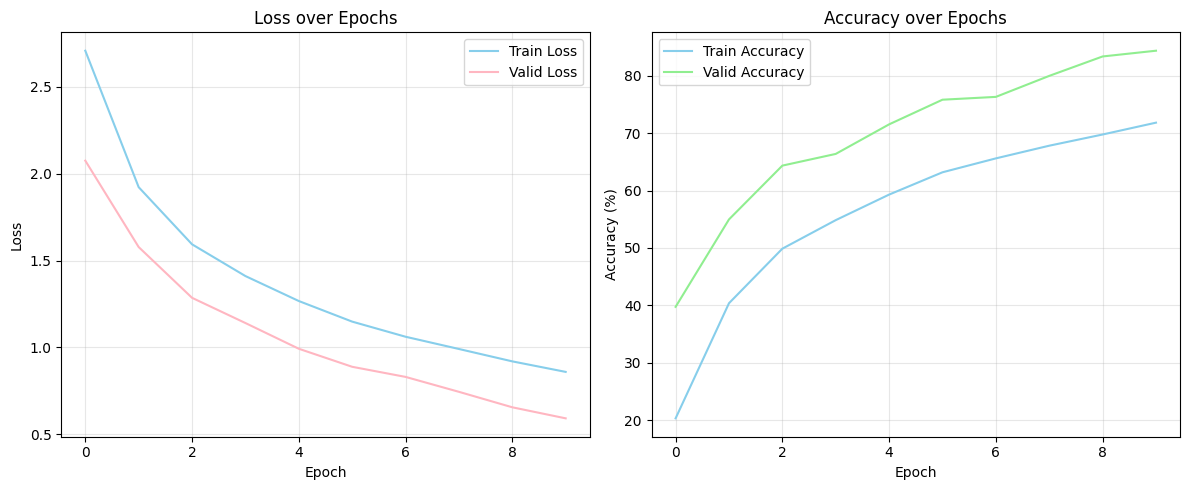

In [ ]:
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#87CEEB')
plt.plot(valid_losses, label='Valid Loss', color='#FFB6C1')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='#87CEEB')
plt.plot(valid_accuracies, label='Valid Accuracy', color='#90EE90')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 최종 테스트 평가

테스트 데이터셋을 사용하여 최종 성능을 평가합니다.

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"최종 테스트 정확도: {test_acc:.2f}%")

최종 테스트 정확도: 84.30%
